# NHANES Hearing Loss Classification Model Training

This notebook trains machine learning models to classify hearing loss based on audiometry data from the NHANES (National Health and Nutrition Examination Survey) dataset.

## Overview
- **Dataset**: NHANES Audiometry Data (AUX_J.xpt)
- **Task**: Multi-class classification of hearing loss severity
- **Models**: Random Forest, Decision Tree, Logistic Regression
- **Features**: Hearing thresholds at different frequencies (500Hz - 8000Hz)
- **Target**: Hearing loss categories (Normal, Mild, Moderate, Severe, Profound)

## Hearing Loss Classification Criteria
Based on Pure-Tone Average (PTA) in dB HL:
- **Normal**: ≤ 25 dB HL
- **Mild**: 26-40 dB HL  
- **Moderate**: 41-60 dB HL
- **Severe**: 61-80 dB HL
- **Profound**: > 80 dB HL

## 1. Import Required Libraries

In [1]:
pip install pandas numpy pyreadstat scikit-learn matplotlib seaborn joblib


Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
Using cached pandas-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 1.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!/usr/bin/env python3
"""
NHANES Hearing Loss Classification Model Training
Based on the SoundCheck application requirements from the hackathon PDF.
"""

import pandas as pd
import numpy as np
import pyreadstat
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Additional imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Loading and Exploration

In [3]:
def load_nhanes_data(file_path):
    """Load NHANES audiometry data from XPT file"""
    print("📊 Loading NHANES audiometry data...")
    df, meta = pyreadstat.read_xport(file_path)
    print(f"✅ Loaded {len(df)} records with {len(df.columns)} columns")
    return df, meta

# Load the data
df, meta = load_nhanes_data('AUX_J.xpt')

# Display basic information about the dataset
print("\n📋 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\n🔍 First 5 rows:")
display(df.head())

print(f"\n📊 Data Types:")
display(df.dtypes.value_counts())

📊 Loading NHANES audiometry data...
✅ Loaded 3131 records with 90 columns

📋 Dataset Overview:
Shape: (3131, 90)

🔍 First 5 rows:


,SEQN,AUAEXSTS,AUAEXCMT,AUQ011,AUQ540,AUQ550,AUQ550A,AUQ550B,AUQ550C,AUQ550D,...,AUXR1K2L,AUXR2KL,AUXR3KL,AUXR4KL,AUXR6KL,AUXR8KL,AUAREQC,AUATYMTR,AUALEQC,AUATYMTL
0,93706.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Type A,1.0,Type A
1,93707.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Type A,1.0,Type A
2,93709.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Type A,1.0,Type A
3,93712.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Type A,1.0,Type A
4,93715.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,60.0,NaN,NaN,NaN,NaN,2.0,Type A,2.0,Type A



📊 Data Types:


float64    88
object      2
Name: count, dtype: int64

## 3. Data Cleaning and Preprocessing

In [4]:
def clean_and_prepare_data(df):
    """Clean and prepare the audiometry data for ML training"""
    print("🧹 Cleaning and preparing data...")
    
    # Define frequency mapping for hearing thresholds
    freq_map = {
        '500': ['AUXU500R', 'AUXU500L'],
        '1000': ['AUXU1K1R', 'AUXU1K1L'], 
        '2000': ['AUXU2KR', 'AUXU2KL'],
        '3000': ['AUXU3KR', 'AUXU3KL'],
        '4000': ['AUXU4KR', 'AUXU4KL'],
        '6000': ['AUXU6KR', 'AUXU6KL'],
        '8000': ['AUXU8KR', 'AUXU8KL']
    }
    
    # Replace invalid values (666, 777, 888) with NaN
    print("🔧 Replacing invalid values...")
    for cols in freq_map.values():
        for col in cols:
            if col in df.columns:
                df[col] = df[col].replace({666: np.nan, 777: np.nan, 888: np.nan})
    
    # Compute average threshold across ears for each frequency
    print("📊 Computing average thresholds across ears...")
    for freq, (r_col, l_col) in freq_map.items():
        if r_col in df.columns and l_col in df.columns:
            df[f'{freq}_avg'] = df[[r_col, l_col]].mean(axis=1)
        elif r_col in df.columns:
            df[f'{freq}_avg'] = df[r_col]
        elif l_col in df.columns:
            df[f'{freq}_avg'] = df[l_col]
    
    # Create Pure-Tone Average (PTA) for 500, 1000, 2000, 4000 Hz
    print("🎯 Computing Pure-Tone Average (PTA)...")
    pta_freqs = ['500_avg', '1000_avg', '2000_avg', '4000_avg']
    available_pta_freqs = [freq for freq in pta_freqs if freq in df.columns]
    
    if available_pta_freqs:
        df['PTA'] = df[available_pta_freqs].mean(axis=1)
    else:
        print("⚠️ Warning: No PTA frequencies available, using available frequencies")
        available_freqs = [f'{freq}_avg' for freq in freq_map.keys() if f'{freq}_avg' in df.columns]
        if available_freqs:
            df['PTA'] = df[available_freqs].mean(axis=1)
    
    return df, freq_map

# Clean the data
df_clean, freq_map = clean_and_prepare_data(df.copy())

print("\n✅ Data cleaning completed!")
print(f"Available frequency columns: {[f'{freq}_avg' for freq in freq_map.keys() if f'{freq}_avg' in df_clean.columns]}")

🧹 Cleaning and preparing data...
🔧 Replacing invalid values...
📊 Computing average thresholds across ears...
🎯 Computing Pure-Tone Average (PTA)...

✅ Data cleaning completed!
Available frequency columns: ['500_avg', '1000_avg', '2000_avg', '3000_avg', '4000_avg', '6000_avg', '8000_avg']


## 4. Feature Engineering and Target Creation

🎯 Preparing features and target...
📊 Available feature columns: ['500_avg', '1000_avg', '2000_avg', '3000_avg', '4000_avg', '6000_avg', '8000_avg']
✅ Clean dataset size: 2521 records

📊 Final dataset shape: (2521, 7)
🎯 Target distribution:


hearing_category
Normal      2017
Mild         282
Moderate     189
Severe        32
Profound       1
Name: count, dtype: int64

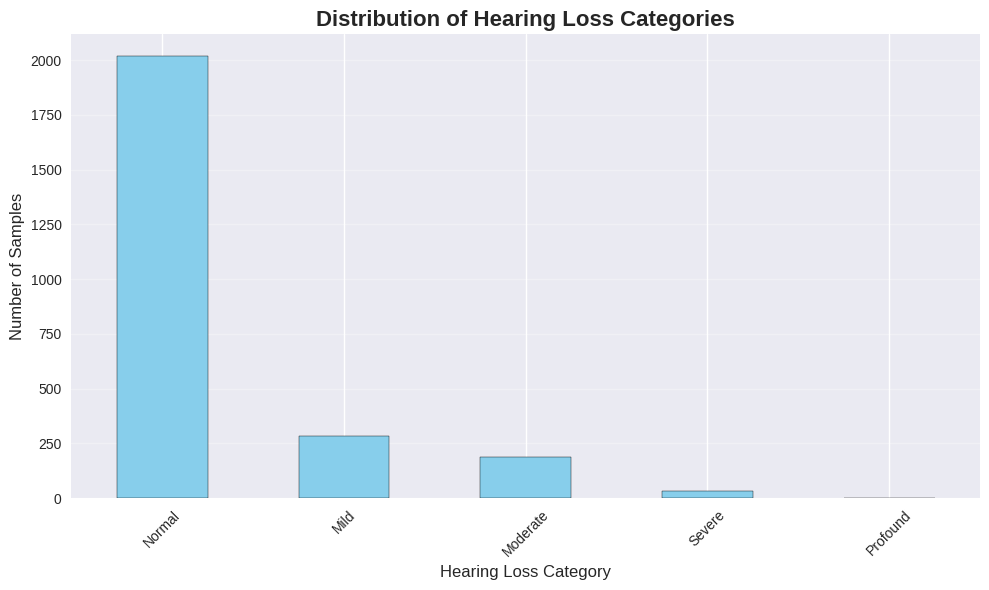


📈 Feature matrix preview:


,500_avg,1000_avg,2000_avg,3000_avg,4000_avg,6000_avg,8000_avg
0,2.5,5.0,5.0,10.0,5.0,7.5,15.0
1,5.0,-2.5,2.5,-5.0,0.0,0.0,-5.0
2,10.0,20.0,30.0,22.5,22.5,27.5,30.0
3,2.5,-5.0,-5.0,5.0,-2.5,7.5,5.0
4,5.0,12.5,35.0,65.0,70.0,62.5,62.5


In [5]:
def classify_hearing_loss(pta):
    """Classify hearing loss based on PTA (Pure-Tone Average)"""
    if pd.isna(pta):
        return np.nan
    elif pta <= 25:
        return 'Normal'
    elif pta <= 40:
        return 'Mild'
    elif pta <= 60:
        return 'Moderate'
    elif pta <= 80:
        return 'Severe'
    else:
        return 'Profound'

def prepare_features_and_target(df, freq_map):
    """Prepare feature matrix X and target vector y"""
    print("🎯 Preparing features and target...")
    
    # Apply hearing loss classification
    df['hearing_category'] = df['PTA'].apply(classify_hearing_loss)
    
    # Create feature matrix using available frequency averages
    feature_cols = [f'{freq}_avg' for freq in freq_map.keys() if f'{freq}_avg' in df.columns]
    
    print(f"📊 Available feature columns: {feature_cols}")
    
    # Drop rows with missing values
    df_clean = df.dropna(subset=feature_cols + ['PTA', 'hearing_category'])
    
    print(f"✅ Clean dataset size: {len(df_clean)} records")
    
    X = df_clean[feature_cols]
    y = df_clean['hearing_category']
    
    return X, y, df_clean

# Prepare features and target
X, y, df_final = prepare_features_and_target(df_clean, freq_map)

print(f"\n📊 Final dataset shape: {X.shape}")
print(f"🎯 Target distribution:")
target_counts = y.value_counts()
display(target_counts)

# Visualize target distribution
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Hearing Loss Categories', fontsize=16, fontweight='bold')
plt.xlabel('Hearing Loss Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 Feature matrix preview:")
display(X.head())

## 5. Exploratory Data Analysis

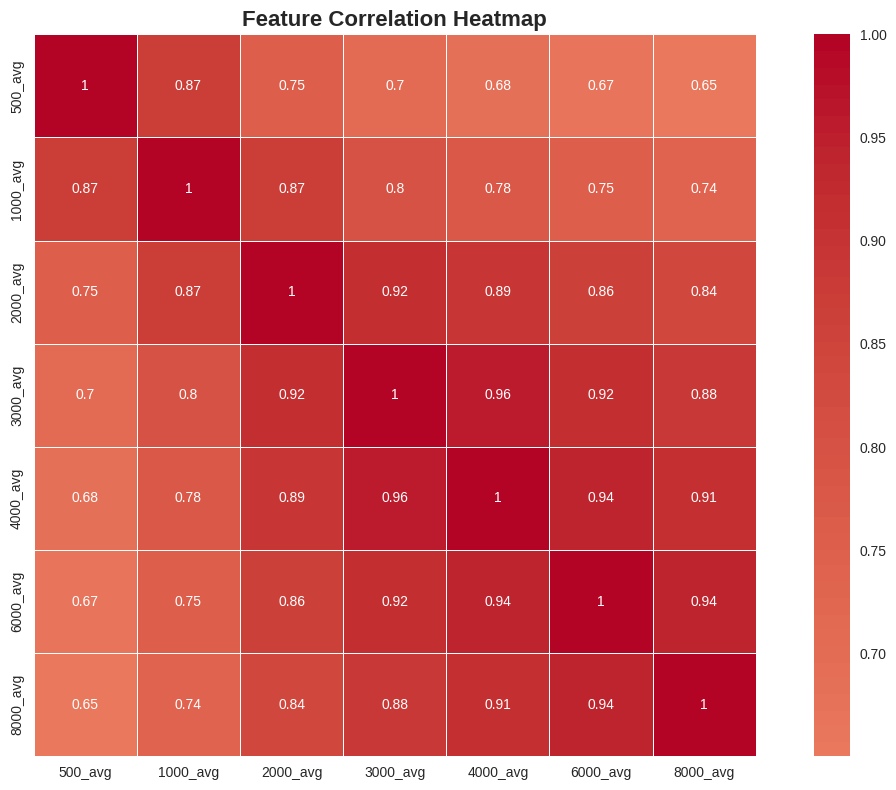

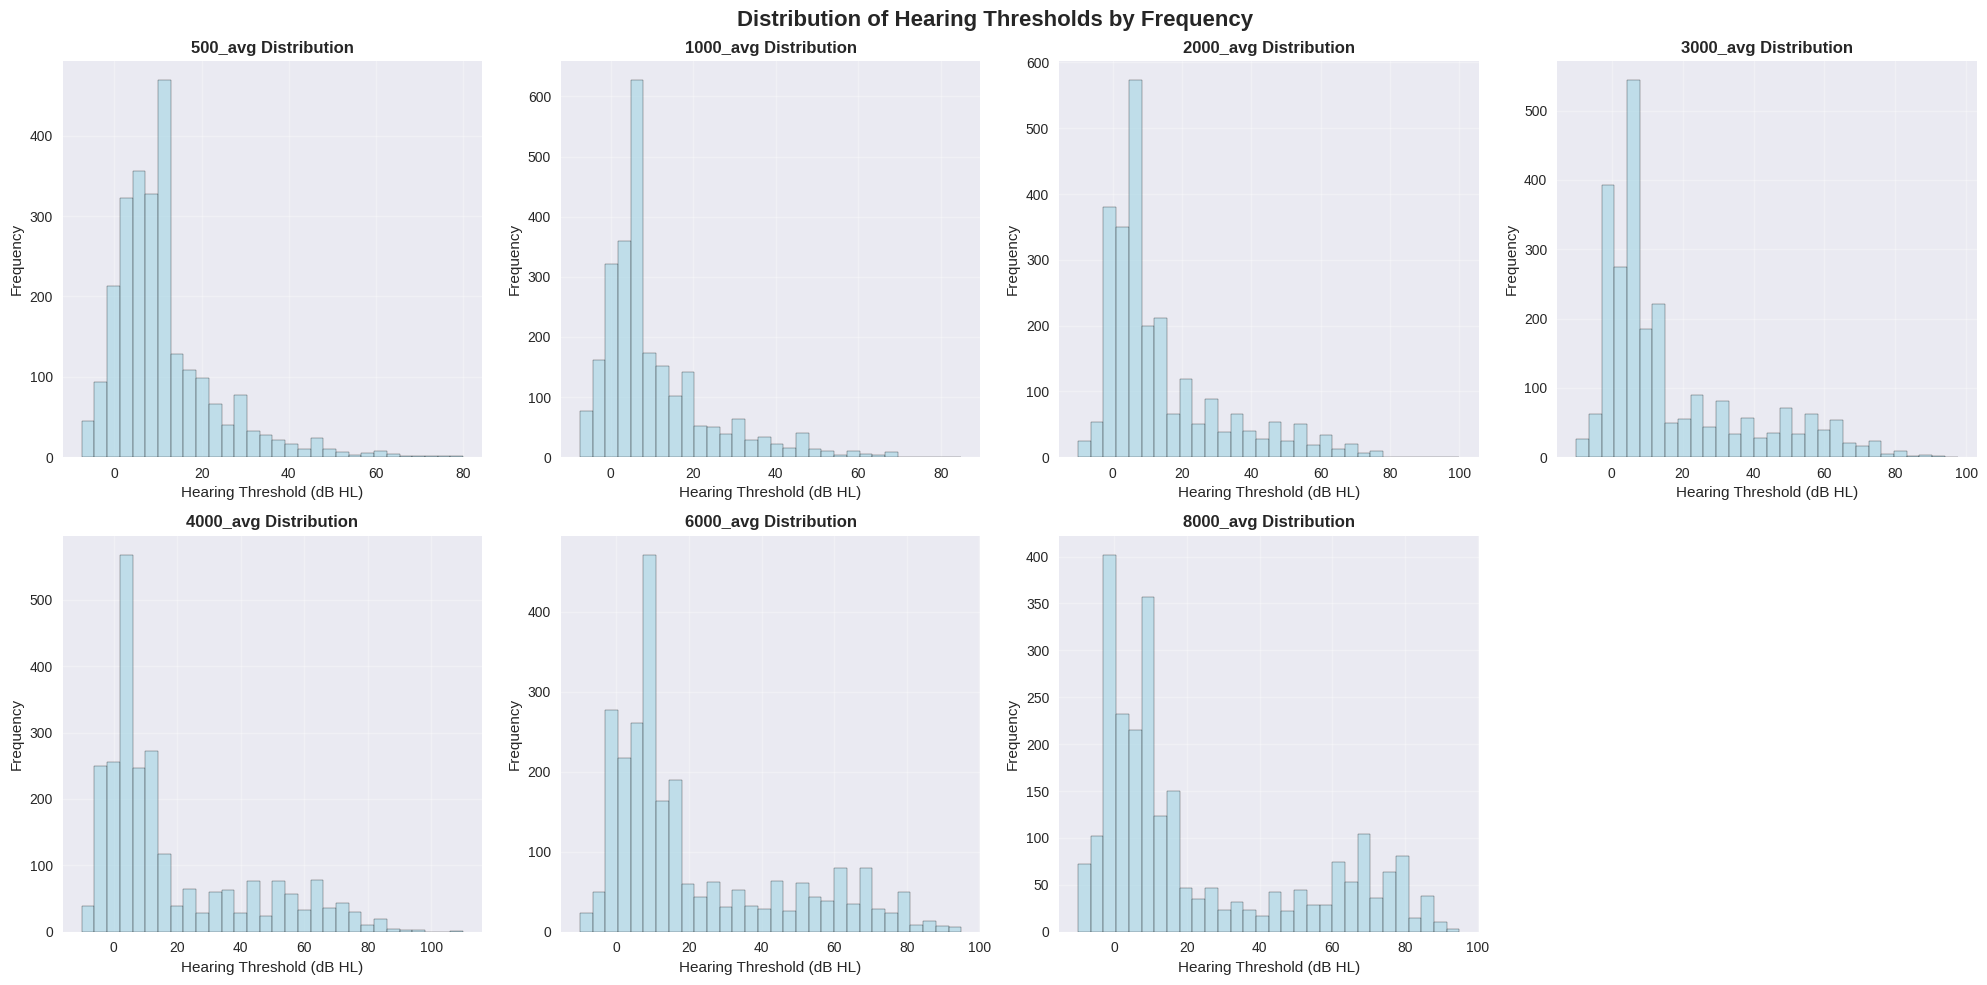

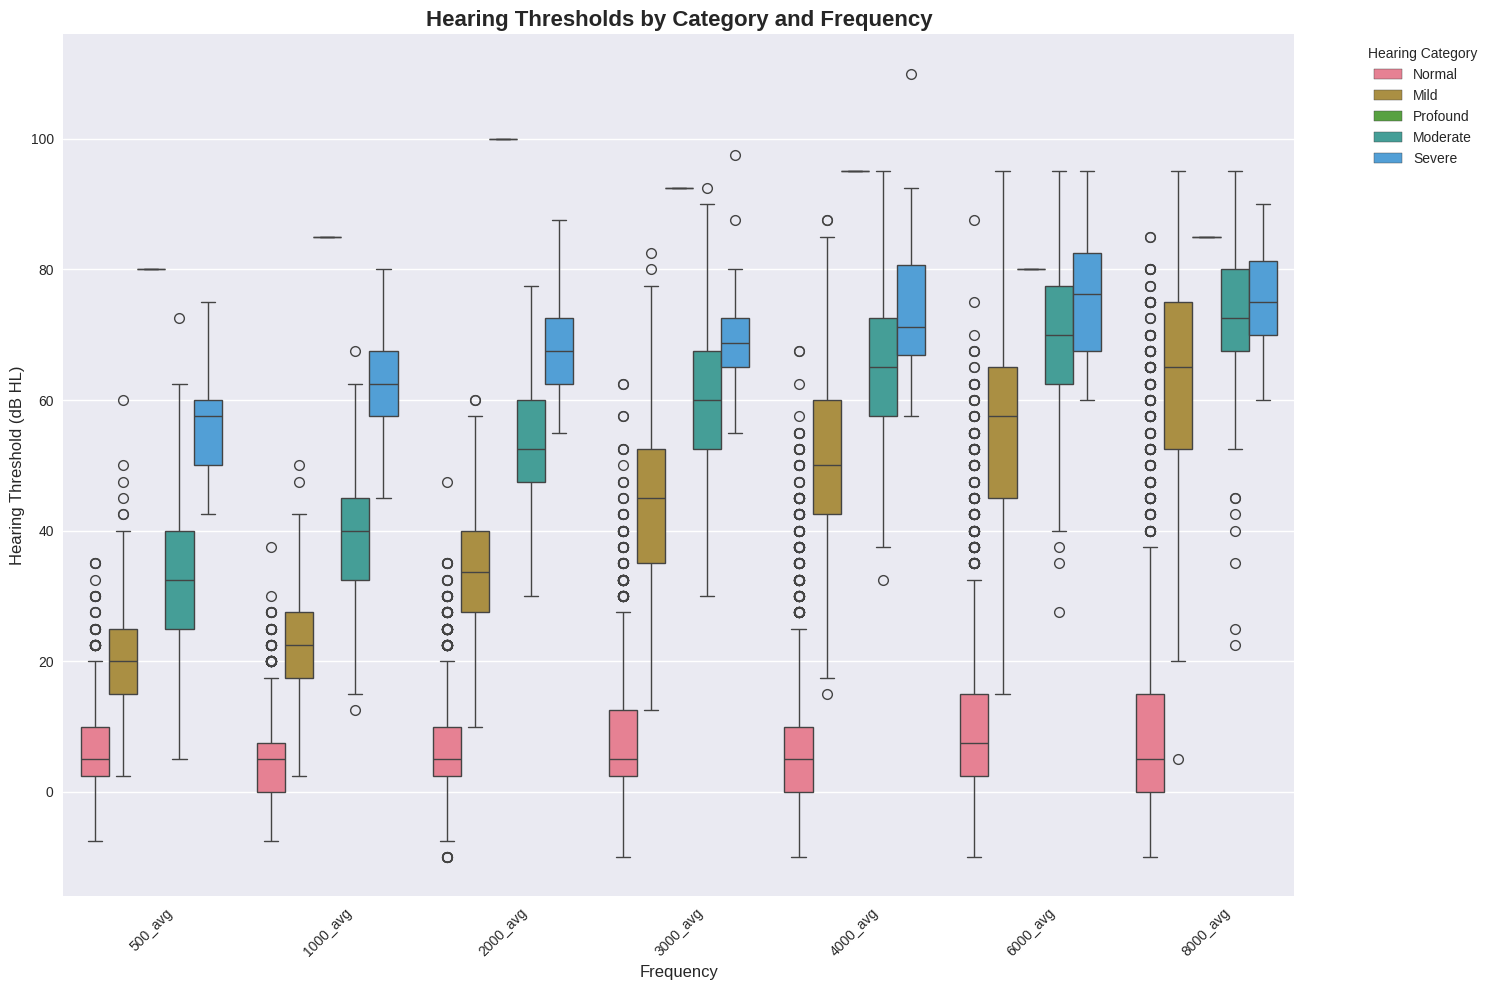

In [6]:
# Correlation heatmap of features
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Distribution of hearing thresholds by frequency
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    if i < len(axes):
        axes[i].hist(X[col].dropna(), bins=30, alpha=0.7, color='lightblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution', fontweight='bold')
        axes[i].set_xlabel('Hearing Threshold (dB HL)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(alpha=0.3)

# Hide empty subplots
for i in range(len(X.columns), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Distribution of Hearing Thresholds by Frequency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Box plots by hearing category
plt.figure(figsize=(15, 10))
df_plot = df_final[list(X.columns) + ['hearing_category']].melt(
    id_vars=['hearing_category'], 
    var_name='Frequency', 
    value_name='Threshold'
)

sns.boxplot(data=df_plot, x='Frequency', y='Threshold', hue='hearing_category')
plt.title('Hearing Thresholds by Category and Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Hearing Threshold (dB HL)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Hearing Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6. Model Training and Comparison

In [7]:
def train_models_with_visualization(X, y):
    """Train multiple ML models and return results with visualizations"""
    print("🤖 Training ML models...")

    # Handle class imbalance - remove classes with too few samples
    class_counts = y.value_counts()
    print(f"📊 Class distribution: {dict(class_counts)}")

    # Filter out classes with only 1 sample for stratification
    min_samples_per_class = 2
    valid_classes = class_counts[class_counts >= min_samples_per_class].index

    if len(valid_classes) < len(class_counts):
        removed_classes = set(class_counts.index) - set(valid_classes)
        print(f"⚠️ Removing classes with < {min_samples_per_class} samples: {removed_classes}")
        mask = y.isin(valid_classes)
        X = X[mask]
        y = y[mask]
        print(f"✅ Filtered dataset size: {len(X)} records")

    # Split the data with stratification if possible
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print("✅ Using stratified split")
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print("⚠️ Using random split (stratification failed)")
    
    # Scale features for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"✅ {name} Train Accuracy: {train_accuracy:.4f}")
        print(f"✅ {name} Test Accuracy: {test_accuracy:.4f}")
        
        results[name] = {
            'model': model,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'accuracy': test_accuracy,  # Keep for backward compatibility
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'scaler': scaler if name == 'Logistic Regression' else None
        }
    
    return results, X_train, X_test, y_train, y_test, scaler

# Train models
if len(X) > 0:
    results, X_train, X_test, y_train, y_test, scaler = train_models_with_visualization(X, y)
    print("\n🎉 Model training completed!")
else:
    print("❌ Error: No valid data available for training!")

🤖 Training ML models...
📊 Class distribution: {'Normal': np.int64(2017), 'Mild': np.int64(282), 'Moderate': np.int64(189), 'Severe': np.int64(32), 'Profound': np.int64(1)}
⚠️ Removing classes with < 2 samples: {'Profound'}
✅ Filtered dataset size: 2520 records
✅ Using stratified split

🔄 Training Random Forest...
✅ Random Forest Train Accuracy: 1.0000
✅ Random Forest Test Accuracy: 0.9702

🔄 Training Decision Tree...
✅ Decision Tree Train Accuracy: 0.9995
✅ Decision Tree Test Accuracy: 0.9603

🔄 Training Logistic Regression...
✅ Logistic Regression Train Accuracy: 0.9940
✅ Logistic Regression Test Accuracy: 0.9901

🎉 Model training completed!


## 7. Model Performance Comparison

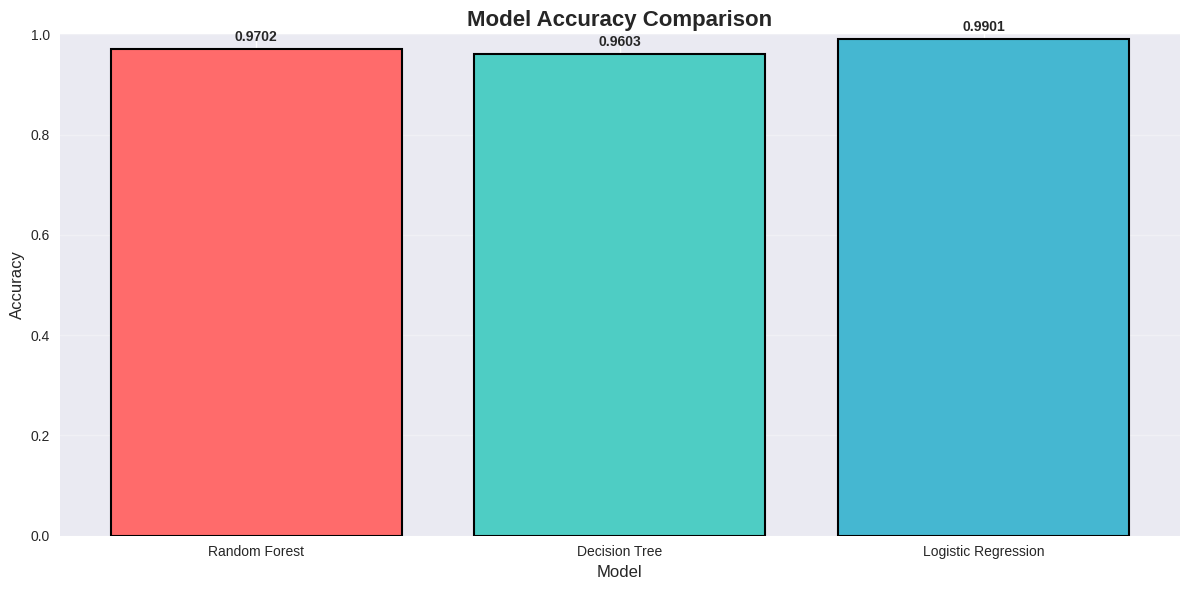


🏆 Best Model: Logistic Regression with accuracy: 0.9901


In [8]:
# Compare model accuracies
if 'results' in locals():
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    
    # Bar plot of model accuracies
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
                   edgecolor='black', linewidth=1.5)
    plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model_name]['accuracy']
    print(f"\n🏆 Best Model: {best_model_name} with accuracy: {best_accuracy:.4f}")

## 8. Detailed Model Evaluation

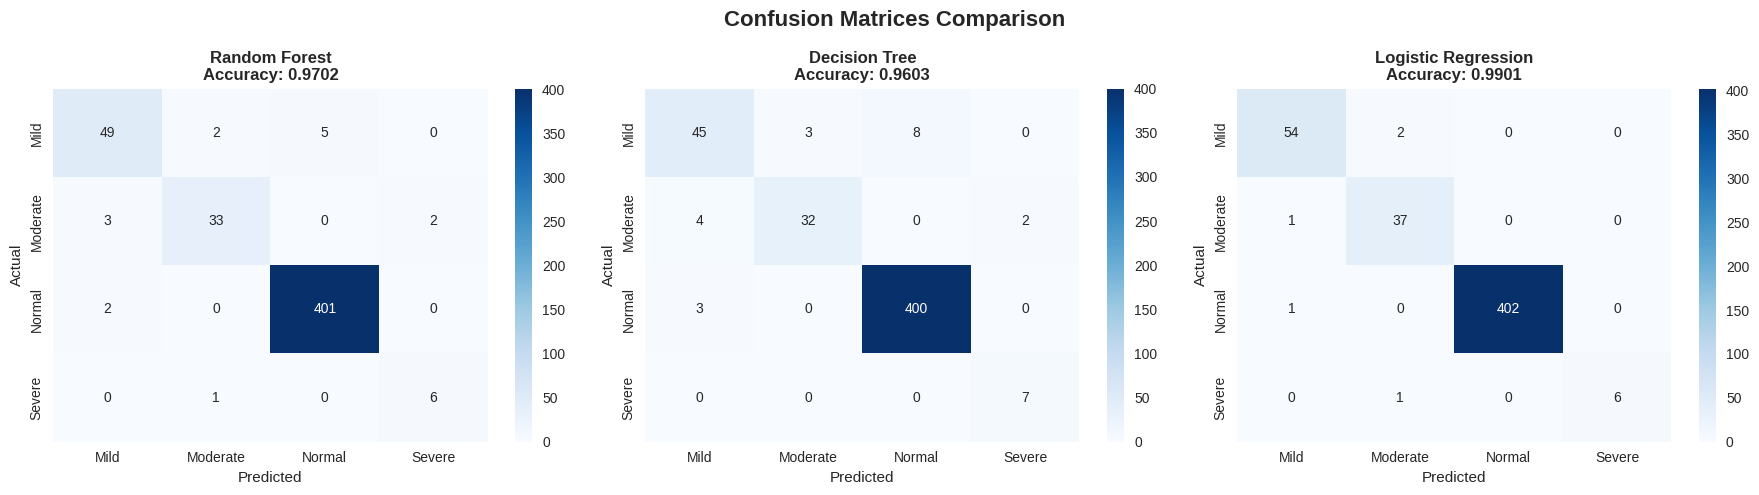


📊 Detailed Classification Reports:

🤖 Random Forest:
----------------------------------------
              precision    recall  f1-score   support

        Mild       0.91      0.88      0.89        56
    Moderate       0.92      0.87      0.89        38
      Normal       0.99      1.00      0.99       403
      Severe       0.75      0.86      0.80         7

    accuracy                           0.97       504
   macro avg       0.89      0.90      0.89       504
weighted avg       0.97      0.97      0.97       504


🤖 Decision Tree:
----------------------------------------
              precision    recall  f1-score   support

        Mild       0.87      0.80      0.83        56
    Moderate       0.91      0.84      0.88        38
      Normal       0.98      0.99      0.99       403
      Severe       0.78      1.00      0.88         7

    accuracy                           0.96       504
   macro avg       0.88      0.91      0.89       504
weighted avg       0.96      0.

In [9]:
# Confusion matrices for all models
if 'results' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (name, result) in enumerate(results.items()):
        cm = confusion_matrix(result['y_test'], result['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=result['model'].classes_,
                   yticklabels=result['model'].classes_)
        axes[i].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}', 
                         fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Classification reports
    print("\n📊 Detailed Classification Reports:")
    print("=" * 80)
    
    for name, result in results.items():
        print(f"\n🤖 {name}:")
        print("-" * 40)
        print(classification_report(result['y_test'], result['y_pred']))

## 9. Feature Importance Analysis

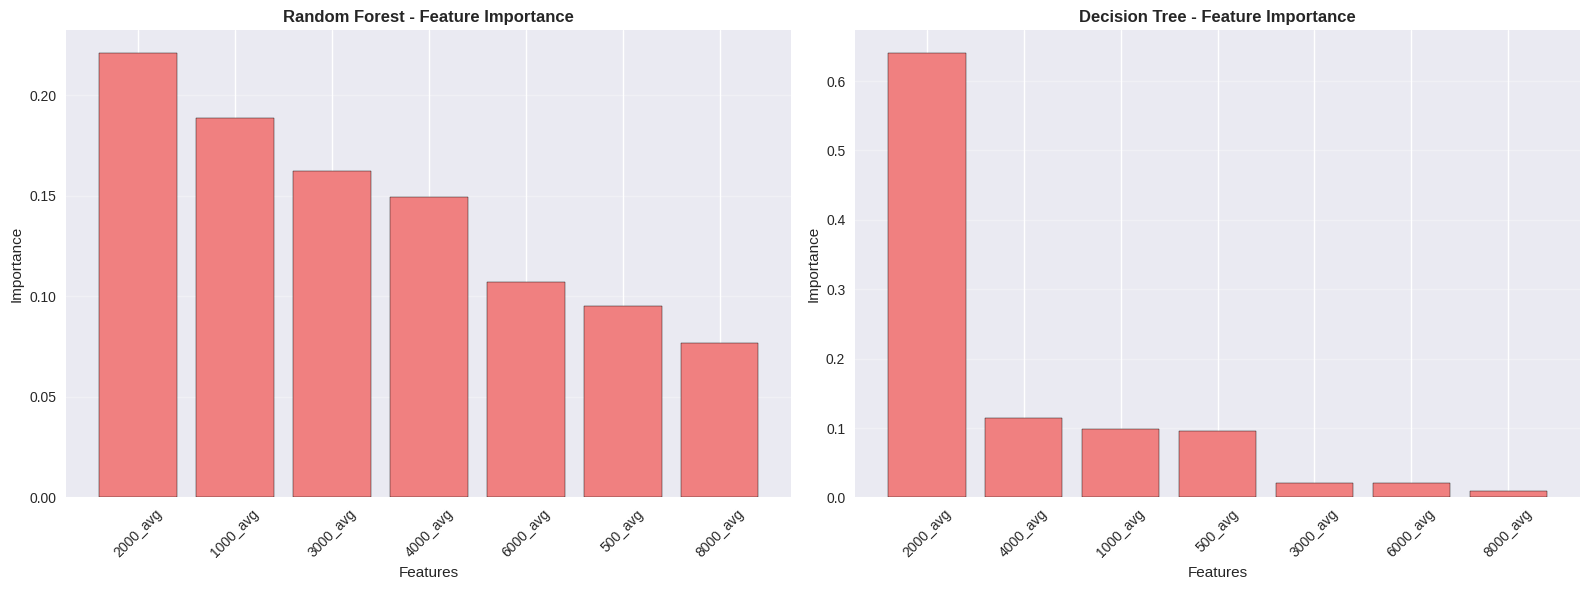


🎯 Feature Importance Rankings:

📊 Random Forest:
------------------------------
2000_avg    : 0.2211
1000_avg    : 0.1884
3000_avg    : 0.1621
4000_avg    : 0.1492
6000_avg    : 0.1070
500_avg     : 0.0953
8000_avg    : 0.0769

📊 Decision Tree:
------------------------------
2000_avg    : 0.6410
4000_avg    : 0.1148
1000_avg    : 0.0983
500_avg     : 0.0956
3000_avg    : 0.0204
6000_avg    : 0.0201
8000_avg    : 0.0099


In [10]:
# Feature importance for tree-based models
if 'results' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    tree_models = ['Random Forest', 'Decision Tree']
    
    for i, model_name in enumerate(tree_models):
        if model_name in results:
            model = results[model_name]['model']
            importances = model.feature_importances_
            feature_names = X.columns
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1]
            
            axes[i].bar(range(len(importances)), importances[indices], 
                       color='lightcoral', edgecolor='black')
            axes[i].set_title(f'{model_name} - Feature Importance', fontweight='bold')
            axes[i].set_xlabel('Features')
            axes[i].set_ylabel('Importance')
            axes[i].set_xticks(range(len(importances)))
            axes[i].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[i].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance rankings
    print("\n🎯 Feature Importance Rankings:")
    print("=" * 50)
    
    for model_name in tree_models:
        if model_name in results:
            model = results[model_name]['model']
            importances = model.feature_importances_
            feature_names = X.columns
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\n📊 {model_name}:")
            print("-" * 30)
            for idx, row in importance_df.iterrows():
                print(f"{row['Feature']:12s}: {row['Importance']:.4f}")

## 10. Model Saving and Deployment Preparation

In [11]:
def save_model_and_artifacts(model, model_name, scaler, feature_names):
    """Save the trained model and related artifacts"""
    print("💾 Saving model and artifacts...")
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Save the model
    model_path = f'models/hearing_classifier_{model_name.lower().replace(" ", "")}.joblib'
    joblib.dump(model, model_path)
    print(f"✅ Model saved to: {model_path}")
    
    # Save scaler if used
    if scaler is not None:
        scaler_path = 'models/scaler.joblib'
        joblib.dump(scaler, scaler_path)
        print(f"✅ Scaler saved to: {scaler_path}")
    
    # Save feature names
    feature_path = 'models/feature_names.joblib'
    joblib.dump(feature_names, feature_path)
    print(f"✅ Feature names saved to: {feature_path}")
    
    # Save model metadata
    metadata = {
        'model_name': model_name,
        'feature_names': feature_names,
        'uses_scaler': scaler is not None,
        'classes': list(model.classes_) if hasattr(model, 'classes_') else None
    }
    
    metadata_path = 'models/model_metadata.joblib'
    joblib.dump(metadata, metadata_path)
    print(f"✅ Model metadata saved to: {metadata_path}")
    
    return model_path, scaler_path if scaler is not None else None, feature_path, metadata_path

# Save the best model
if 'results' in locals() and 'best_model_name' in locals():
    best_model = results[best_model_name]['model']
    best_scaler = results[best_model_name]['scaler']
    
    model_path, scaler_path, feature_path, metadata_path = save_model_and_artifacts(
        best_model, best_model_name, best_scaler, list(X.columns)
    )
    
    print(f"\n🎉 Best model ({best_model_name}) saved successfully!")
else:
    print("⚠️ No models to save.")

💾 Saving model and artifacts...
✅ Model saved to: models/hearing_classifier_logisticregression.joblib
✅ Scaler saved to: models/scaler.joblib
✅ Feature names saved to: models/feature_names.joblib
✅ Model metadata saved to: models/model_metadata.joblib

🎉 Best model (Logistic Regression) saved successfully!


## 11. Training Summary and Results

In [12]:
# Final summary
if 'results' in locals():
    print("\n" + "="*80)
    print("🎯 TRAINING SUMMARY")
    print("="*80)
    
    print(f"\n📊 Dataset Information:")
    print(f"   • Total samples: {len(X)}")
    print(f"   • Features: {list(X.columns)}")
    print(f"   • Classes: {sorted(y.unique())}")
    print(f"   • Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\n🤖 Model Performance:")
    for name, result in results.items():
        print(f"   • {name:20s}:")
        print(f"     - Train Accuracy: {result['train_accuracy']:.4f}")
        print(f"     - Test Accuracy:  {result['test_accuracy']:.4f}")
    
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   • Train Accuracy: {results[best_model_name]['train_accuracy']:.4f}")
    print(f"   • Test Accuracy:  {results[best_model_name]['test_accuracy']:.4f}")
    print(f"   • Uses Scaler: {'Yes' if best_scaler is not None else 'No'}")
    
    print(f"\n💾 Saved Files:")
    if 'model_path' in locals():
        print(f"   • Model: {model_path}")
        if scaler_path:
            print(f"   • Scaler: {scaler_path}")
        print(f"   • Features: {feature_path}")
        print(f"   • Metadata: {metadata_path}")
    
    print(f"\n📈 FINAL ACCURACY RESULTS:")
    print(f"   ╔═══════════════════════════════════════════════════════════╗")
    print(f"   ║                    TRAIN vs TEST ACCURACY                 ║")
    print(f"   ╠═══════════════════════════════════════════════════════════╣")
    for name, result in results.items():
        train_acc = result['train_accuracy']
        test_acc = result['test_accuracy']
        print(f"   ║ {name:20s} │ Train: {train_acc:.4f} │ Test: {test_acc:.4f} ║")
    print(f"   ╚═══════════════════════════════════════════════════════════╝")
    
    print(f"\n✅ Training completed successfully!")
    print(f"🚀 The model is ready for deployment in the SoundCheck application.")
    print("="*80)
else:
    print("❌ Training failed - no results available.")


🎯 TRAINING SUMMARY

📊 Dataset Information:
   • Total samples: 2521
   • Features: ['500_avg', '1000_avg', '2000_avg', '3000_avg', '4000_avg', '6000_avg', '8000_avg']
   • Classes: ['Mild', 'Moderate', 'Normal', 'Profound', 'Severe']
   • Train/Test split: 2016/504

🤖 Model Performance:
   • Random Forest       :
     - Train Accuracy: 1.0000
     - Test Accuracy:  0.9702
   • Decision Tree       :
     - Train Accuracy: 0.9995
     - Test Accuracy:  0.9603
   • Logistic Regression :
     - Train Accuracy: 0.9940
     - Test Accuracy:  0.9901

🏆 Best Model: Logistic Regression
   • Train Accuracy: 0.9940
   • Test Accuracy:  0.9901
   • Uses Scaler: Yes

💾 Saved Files:
   • Model: models/hearing_classifier_logisticregression.joblib
   • Scaler: models/scaler.joblib
   • Features: models/feature_names.joblib
   • Metadata: models/model_metadata.joblib

📈 FINAL ACCURACY RESULTS:
   ╔═══════════════════════════════════════════════════════════╗
   ║                    TRAIN vs TEST ACCURA